#### Experiment Portion of ks-folds 
* total size of users (30, 50, 70)
* portion of target group in population (0.5, 0.7, 0.8, 0.9 1.0)

In [1]:
import os
import sys
import glob
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph

from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean

import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
import scipy as sp
import numpy as np
import pandas as pd

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph
from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean


import scipy as sp
import numpy as np
import pandas as pd

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph
from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean


def user_grouped_dist(user_id, weights, profile_df, friend_networkx):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

    Parameters:
    ----------
    * user_id: {integer}, the target user's ID
    * weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    * friend_networkx: {networkx.Graph()}, Graph() object from Networkx
        to store the relationships informat
    Returns:
    -------
    res: {list, list of integers}, a list of two lists, which store the distances
        of either friends and non-friends separately.

    Examples:
    ---------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[ ["ID"] + cols ]
    user_dist = user_grouped_dist(user_id = 0, weights = weights
        , profile_df, friends_df)
    print user_dist["friends"]
    print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # user_row = profile_df.ix[profile_df.ID == user_id, cols]
    # user_profile = user_row.values.tolist()[0]
    # get the user_id of friends of the target user
    friends_ls = friend_networkx.neighbors(user_id)
    all_ids = profile_df.ID
    non_friends_ls = [u for u in all_ids if u not in friends_ls + [user_id]]

    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        # friend_row = profile_df.ix[profile_df.ID == f_id, cols]
        # friend_profile = friend_row.values.tolist()[0]
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)

    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=False, _n=100):

    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    # is_valid = (len(sim_dist_vec) >= min_nobs) & \
    #           (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1], _n)

        # ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]

    return res


def users_filter_by_weights(weights, profile_df, friends_networkx,
                            pval_threshold=0.5,
                            mutate_rate=0.4,
                            min_friend_cnt=10,
                            users_list=None,
                            fit_rayleigh=False,
                            _n=1000,
                            is_debug=False):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

    Parameters:
    ----------
    weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    pval_threshold: {float}, the threshold for p-value to reject hypothesis
    min_friend_cnt: {integer}, drop users whose total of friends is less than
       this minimum count
    mutate_rate: {float}, a float value [0 - 1] determine the percentage of
       bad_fits member sent to mutation
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution
    is_debug: {boolean}, to control if it yeilds by-product information

    Returns:
    -------
    res: {list} grouped list of user ids
        res[0] stores all users whose null hypothesis does not holds;
        res[1] stores all users whose null hypothesis hold null hypothesis,
        given weights, distance distribution of all friends is significantly
        different from distance distribution of all non-friends

    Examples:
    --------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[["ID"] + cols]
    grouped_users = users_filter_by_weights(weights,
                       profile_df, friends_df, pval_threshold = 0.10,
                       min_friend_cnt = 10)

    Notes:
    -----
    min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    if users_list is None:
        users_list = list(profile_df.ix[:, 0])

    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_networkx)
        pval = user_dist_kstest(res_dists[0], res_dists[1], fit_rayleigh, _n)
        pvals.append(pval)

    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])

    if is_debug:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]
        good_pvals = [p for i, p in sorted_id_pval if p < pval_threshold]
        bad_pvals = [p for i, p in sorted_id_pval if p >= pval_threshold]
    else:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]

    if len(bad_fits) > 0:
        mutate_size = np.ceil(len(bad_fits) * mutate_rate)
        mutate_size = max(int(mutate_size), 1)
        id_retain = good_fits + bad_fits[mutate_size:]
        id_mutate = bad_fits[:mutate_size]
        # split pval
        if is_debug:
            if len(good_pvals) > 0 or len(bad_pvals) > 0:
                pval_retain = good_pvals + bad_pvals[mutate_size:]
                pval_mutate = bad_pvals[mutate_size:]
    else:
        id_retain = good_fits
        id_mutate = bad_fits

        if is_debug:
            if len(good_pvals) > 0 or len(bad_pvals) > 0:
                pval_retain = pval_retain
                pval_mutate = bad_pvals

    if is_debug:
        res = [id_retain, id_mutate, pval_retain, pval_mutate]
    else:
        res = [id_retain, id_mutate]

    return res


def ldm_train_with_list(users_list, profile_df, friends, retain_type=1):
    """ learning distance matrics with ldm() instance, provided with selected
        list of users.

    Parameters:
    -----------
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends: {list of tuple}, each tuple keeps a pair of user id
    retain_type: {integer}, 0, adopting 'or' logic by keeping relationship in
        friends_df if either of entities is in user_list 1, adopting 'and'
        logic

    Returns:
    -------
    res: {vector-like, float}, output of ldm.get_transform_matrix()

    Examples:
    ---------
    new_dist_metrics = ldm_train_with_list(user_list, profile_df, friends_df)
    """
    if retain_type == 0:
        friends = [(a, b) for a, b in friends if \
            a in users_list or b in users_list]
    else:
        friends = [(a, b) for a, b in friends if \
            a in users_list and b in users_list]

    ldm = LDM()
    ldm.fit(profile_df, friends)
    weight_vec = ldm.get_transform_matrix()
    return weight_vec

def init_embed_list(n):
    """
    """
    ls = []
    for i in range(n):
        ls.append([])
    return ls

def init_dict_list(k):
    """ create dictionary with k items, each
        item is a empty list
    """
    res_dict = {}
    for i in range(k):
        res_dict[i] = []
    return res_dict


def find_fit_group(uid, dist_metrics, profile_df,
                   friend_networkx, threshold=0.5,  current_group = None):
    """ calculate user p-value for the distance metrics of
        each group

    Parameters:
    ----------
    uid: {integer}, user id
    dist_metrics: {dictionary}, all {index: distance_metrics}
    profile_df: {DataFrame}, user profile includes "ID" column
    friend_networkx: {networkx.Graph}, user relationships
    threshold: {float}, threshold for qualifying pvalue of ks-test
    current_group: {integer}, group index

    Resutls:
    --------
    res: {list}, [group_idx, pvalue]
    """
    if current_group is None:
        other_group = dist_metrics.keys()
        other_dist_metrics = dist_metrics.values()
    else:
        other_group = [i for i in dist_metrics.keys() if i != current_group]
        other_dist_metrics = [d for g, d in dist_metrics.iteritems() if g != current_group]

    if len(other_dist_metrics) > 0:
        # only excute this is at least one alternative group
        pvals = []

        for d in other_dist_metrics:
            # loop through all distance metrics and calculate
            # p-value of ks-test by applying it to the user
            # relationships
            sdist, ddist = user_grouped_dist(uid, d, profile_df,
                                         friend_networkx)
            pval = user_dist_kstest(sdist, ddist, fit_rayleigh=True, _n=n)
            pvals.append(pval)

        min_pval = min(pvals)
        min_index = [i for i, p in enumerate(pvals) if p == min_pval][0]
        best_group = other_group[min_index]

        if min_pval >= threshold:
            # if min_pval >= threshold, user is not considered
            # to have a good fit by any of distance metrics
            best_group = None
            min_pval = None

    else:
        best_group = None
        min_pval = None

    return (best_group, min_pval)

def get_fit_score(fit_pvals, buffer_group, c, t=2):
    """ calculate the fit score given the member composite
        and its pvalues with its group distance metrics, with
        c determinng the strength of penalty for keeping a
        larger number of users in buffer_group

    Parameters:
    -----------
    fit_pvals: {dict}, {index: [pvalues]}
    buffer_group: {list}, [userid, ...]
    c: {float},
    t: {integer} 1, 2 or 3, type of fit score

    Returns:
    --------
    fit_score: {float}, fit score, a smaller value indidcate
                a overall better fit

    Examples:
    ---------
    fit_group = fit_group
    fit_pvals = fit_pvals
    buffer_group = buffer_group
    c = 0.1
    fscore = get_fit_score(fit_group, fit_pvals, buffer_group, c)
    """

    # weighted sum of pvalues
    if t not in [1, 2, 3]:
        raise NameError('Error: type (t) is not legal value (1 or 2)!')

    wsum_pval = 0
    if t == 1:
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v) * 1.0 / len(v))
    if t == 2:
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v)) * 1.0 / (len(v) * len(v))
    if t == 3:
        num_users = 0
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v)) * 1.0 / (len(v) * len(v))
            num_users += len(v)
        wsum_pval = num_users * 1.0 * wsum_pval

    penalty = c * len(buffer_group)
    fit_score = wsum_pval + penalty # smaller value indicates a better overall fit

    return fit_score


def learning_wrapper(profile_df, friends_pair, k, t=2, c=0.1,
                     threshold_max=0.5, threshold_min=0.2,
                     min_size_group=10, min_delta_f=0.02,
                     max_iter=5, n=1000):
    """ learn the groupings and group-wise distance metrics

    Parameters:
    ----------
    profile_df: {pd.DataFrame}, with column ID and other attributes
    friends_pair: {list}, consisted of tuples of user id pairs
    k: {integer}, # of groups in the population
    t: {integ}, type of fit score
    c: {float}, strength of penalty for larger size of buffer group
    threshold_max: {float}, from 0 to 1, the initial threshold for ks-test
    threshold_min: {float}, form 0 to 1, the mimum possible threhsold for ks-test
    min_size_group: {integer}, minimal group size
    min_delta_f: {float}, minmal reduction considered substantial improvement
    max_iter: {integer}, maxmium number of sequential iterations with
        non-substantial improvement in fit score
    n: {integer}, the samples of Rayleigh distribution for ks-test,
        it influence the sensitivity of KS-test

    Returns:
    -------
    res: {tuple}, (best_knowledge, best_fs)
    best_knowledge: {dictionary}, {"dist_metrics", "fit_group", "buffer_group"}
    best_fs: {float}, best fit score

    Examples:
    --------
    learning_wrapper(profile_df, friends_pair, k=2)
    """

    from networkx import Graph

    # convert pair-wise relationship data into Graph
    friend_networkx = Graph()
    friend_networkx.add_edges_from(friends_pair)

    # initiate the containers:
    # dist_metrics: ldm() with subset of users
    # fit_group: subsets of users
    # buffer_group: useres are not sampled
    dist_metrics = init_dict_list(k) # distance metrics containers
    fit_group    = init_dict_list(k)    # members composition in fit groups
    fit_pvals    = init_dict_list(k)    # members' pvalue of KStest with their group distance metrics
    unfit_group  = init_dict_list(k)  # members is not considerd fit by its group distance metrics
    unfit_pvals  = init_dict_list(k)  # pvalues for members in unfit_group (maybe can be deleted)
    buffer_group = []                # members are not considered having fit

    # results container
    fs_hist = []       # list of fit scores in sequence (lastest one is the last)
    knowledge_pkg = [] # {index: {"dist_metrics", "fit_group", "buffer_group"}}
    threhold = threshold_max

    # provide initial composition of fit_group
    # and buffer_group for iterative learning
    # procedure
    # the even size sampling strategy is implemeted
    # here, however,
    # benford's law can be used as alternative stratgey
    al_ids = list(set(profile_df.ID))
    samp_size = len(all_uids) / k
    samp_sizes = [samp_size] * k
    all_uids_copy = [i for i in all_uids]

    # generate k groups of sample user groups
    for g, samp_size in zip(range(k), samp_sizes):
        # draw samples and assign them to fit_group
        samples = choice(all_uids_copy, samp_size, replace=False)
        fit_group[g] = list(samples)
        # remove samples from population pool
        for uid in samples:
            all_uids_copy.remove(uid)

    # initiate fit user pvals
    for g, uids in fit_group.iteritems():
        fit_pvals[g] = [0] * len(uids)

    # time counter()
    durations = []

    # iteration meters
    _no_imp_counter = 0
    _loop_counter = 0

    while _no_imp_counter < max_iter:

        _loop_counter += 1
        print "%d iteration is in processing ..." % _loop_counter

        # step 01: learn distance metrics
        for g, uids in fit_group.iteritems():
            # learn distance metrics
            # here to update the computational mechanism
            # dist = [np.random.uniform(0, 1, 1)[0] for i in range(4)]
            if len(uids) >= min_size_group:
                dist = ldm_train_with_list(uids, profile_df, friends_ls)
                dist_metrics[g] = dist
            else:
                num_feat = profile_df.shape[1] - 1
                ist_metrics[g] = [1] * num_feat

        # step 02: update the member composite with updated group
        # distance metrics threshold is needed to be defined
        fit_group_copy = {k:[i for i in v] for k, v in fit_group.iteritems()}
        for g, uids in fit_group_copy.iteritems():
            target_dist = dist_metrics[g]

            for uid in uids:
                sdist, ddist = user_grouped_dist(uid, dist_metrics, profile_df,
                                          friends_networkx)
                pval = user_dist_kstest(sdist, ddist, fit_rayleigh=True, _n=n)

                if pval >= threshold:
                    # remove the user and its information
                    # from relevant container
                    idx = [i for i, u in enumerate(fit_group[g]) if u == uid][0]
                    fit_group[g].pop(idx)
                    fit_pvals[g].pop(idx)

                     # add the user to the unfit_group
                    if g in unfit_group:
                        unfit_group[g].append(uid)
                    else:
                        unfit_group[g] = [uid]

                else:
                    idx = [i for i, u in enumerate(fit_group[g]) if u == uid][0]
                    fit_pvals[g][idx] = pval


        # step 03: test members in unfit_group to see
        # if it has a good fit with other distmetrics
        # make a copy of the buffer group container
        buffer_group_copy = [i for i in buffer_group]
        if len(buffer_group_copy) > 0:
            for uid in buffer_group_copy:
                new_group, new_pval = find_fit_group(uid, dist_metrics, threshold)
                if new_group is not None:
                    buffer_group.remove(uid)
                    if new_group in fit_group:
                        fit_group[new_group].append(uid)
                        fit_pvals[new_group].append(new_pval)
                    else:
                        fit_group[new_group] = [uid]
                        fit_pvals[new_group] = [new_pval]

        unfit_group_copy = {k:[i for i in v] for k, v in unfit_group.iteritems()}
        for g, uids in unfit_group_copy.iteritems():
            for uid in uids:
                new_group, new_pval = find_fit_group(uid, dist_metrics, threshold, g)
                unfit_group[g].remove(uid)

                if new_pval is None:
                    buffer_group.append(uid)
                else:
                    if new_group in fit_group:
                        fit_group[new_group].append(uid)
                        fit_pvals[new_group].append(new_pval)
                    else:
                        fit_group[new_group] = [uid]
                        fit_pvals[new_group] = [new_pval]

        # step 04: calculate fit score
        fs = get_fit_score(fit_pvals, buffer_group, c=c, t=1)
        fs_hist.append(fs)

        # step 05: evaluate stop criteria
        package = {"dist_metrics": dist_metrics,
                   "fit_group": fit_group,
                   "buffer_group": buffer_group}

        knowledge_pkg.append(package)
        best_fs = min(fs_hist)

        if best_fs - fs <= min_delta_f:
            _no_imp_counter += _no_imp_counter
        else:
            _no_imp_counter = 0
            if threshold > threshold_min:
                threshold -= 0.01

    # print "fit score (type-%d): %.3f" % (t, fs)
    # print "best fit score: %.3f" % best_fs
    best_idx = [i for i, fs in enumerate(fs_hist) if fs == best_fs]
    best_knowledge = knowledge_pkg[best_idx]
    return (best_knowledge, best_fs)

In [9]:
DATA_PATH = "./data/sim_data_yi/" 

users_df   = pd.read_csv(DATA_PATH + "users_profile.csv", header = 0, sep = ",")
friends_df = pd.read_csv(DATA_PATH + "friendships.csv", header = 0, sep = ",")
dist_df    = pd.read_csv(DATA_PATH + "dist_mat.csv", header = 0, sep = ",")

friends_df = friends_df[friends_df.isFriend == 1]
friends_df["pair"] = friends_df[["uid_a", "uid_b"]].apply(lambda x: (int(x[0]), int(x[1])), axis=1)
friends_df.drop("isFriend", axis=1, inplace=True)
friends_df = friends_df[["pair", "uid_a", "uid_b"]]
friends_df.head(3)

cols = ["x0", "x1", "x2", "x3", "x4", "x5"]

## subset users data to retain profile only
profile_df = users_df[["ID"] + cols]
all_user_ids = list(set(users_df.ID))

friends_ls = list(friends_df.pair)

In [6]:
group0_uids = list(users_df.ix[users_df.decision_style == 0, "ID"])
group1_uids = list(users_df.ix[users_df.decision_style == 1, "ID"])

In [231]:
num_folds = 10
sample_sizes = [20, 30, 50, 60]
tgroup_ptgs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

samp_size_vec = []
target_portion = []
learned_dist = [] 

counter = 0
for sample_size in sample_sizes:
    for ptg in tgroup_ptgs:
        g0_size = round(sample_size * ptg)
        g1_size = max(sample_size - g0_size, 0)
        for fold in range(num_folds):
            print "%d th iteration..." % counter
            g0_samples = np.random.choice(group0_uids, g0_size)
            g1_samples = np.random.choice(group1_uids, g1_size)
            subjects = list(g0_samples) + list(g1_samples)
            res_dist = ldm_train_with_list(subjects, profile_df, friends_ls, retain_type=1)
            
            counter += 1
            
            samp_size_vec.append(sample_size)
            target_portion.append(ptg)
            learned_dist.append(res_dist)

0 th iteration...
--- 46.06 seconds ---
1 th iteration...
--- 98.75 seconds ---
2 th iteration...
--- 55.45 seconds ---
3 th iteration...
--- 57.44 seconds ---
4 th iteration...
--- 43.33 seconds ---
5 th iteration...
--- 67.53 seconds ---
6 th iteration...
--- 45.33 seconds ---
7 th iteration...
--- 32.54 seconds ---
8 th iteration...
--- 75.95 seconds ---
9 th iteration...
--- 41.12 seconds ---
10 th iteration...
--- 58.01 seconds ---
11 th iteration...
--- 71.00 seconds ---
12 th iteration...
--- 37.27 seconds ---
13 th iteration...
--- 47.32 seconds ---
14 th iteration...
--- 48.44 seconds ---
15 th iteration...
--- 32.22 seconds ---
16 th iteration...
--- 53.82 seconds ---
17 th iteration...
--- 63.84 seconds ---
18 th iteration...
--- 56.11 seconds ---
19 th iteration...
--- 50.53 seconds ---
20 th iteration...
--- 59.86 seconds ---
21 th iteration...
--- 33.88 seconds ---
22 th iteration...
--- 48.59 seconds ---
23 th iteration...
--- 61.04 seconds ---
24 th iteration...
--- 49.

In [200]:
true_dist_0 = [0.5, 0.5, 0.1, 0, 0, 0]
true_dist_1 = [0, 0, 0, 0.5, 0.3, 0.2]

In [233]:
from scipy.spatial.distance import cosine
from math import acos

# calcualte the 
diff = []
for d in learned_dist:
    diff_cosine = cosine(d, true_dist_0)
    #theta = diff_cosine
    diff.append(diff_cosine)
    
eval_df = pd.DataFrame({"samp_size": samp_size_vec,
                        "target_portion": target_portion,
                        "learned_distance": learned_dist,
                        "theta": diff})

In [234]:
eval_df.tail(10)

,learned_distance,samp_size,target_portion,theta
390,"[0.42, 0.58, 0.0, 0.0, 0.0, 0.0]",60,1,0.022288
391,"[0.53, 0.47, 0.0, 0.0, 0.0, 0.0]",60,1,0.011630
392,"[0.54, 0.46, 0.0, 0.0, 0.0, 0.0]",60,1,0.013006
393,"[0.44, 0.56, 0.0, 0.0, 0.0, 0.0]",60,1,0.016905
394,"[0.58, 0.42, 0.0, 0.0, 0.0, 0.0]",60,1,0.022288
395,"[0.42, 0.58, 0.0, 0.0, 0.0, 0.0]",60,1,0.022288
396,"[0.38, 0.62, 0.0, 0.0, 0.0, 0.0]",60,1,0.037193
397,"[0.42, 0.58, 0.0, 0.0, 0.0, 0.0]",60,1,0.022288
398,"[0.53, 0.47, 0.0, 0.0, 0.0, 0.0]",60,1,0.011630
399,"[0.52, 0.48, 0.0, 0.0, 0.0, 0.0]",60,1,0.010644


In [235]:
eval_sum = eval_df.groupby(["samp_size", "target_portion"])["theta"].agg([np.mean, np.median, np.std])

In [243]:
eval_sum["u95"] = eval_sum.apply(lambda x: x["mean"] + 1.96 * x["std"], axis=1)
eval_sum["l05"] = eval_sum.apply(lambda x: x["mean"] - 1.96 * x["std"], axis=1)
eval_sum["l05"] = eval_sum["l05"].apply(lambda x: 0 if x < 0 else x)

In [244]:
min(eval_df.theta)

0.0013759525494588809

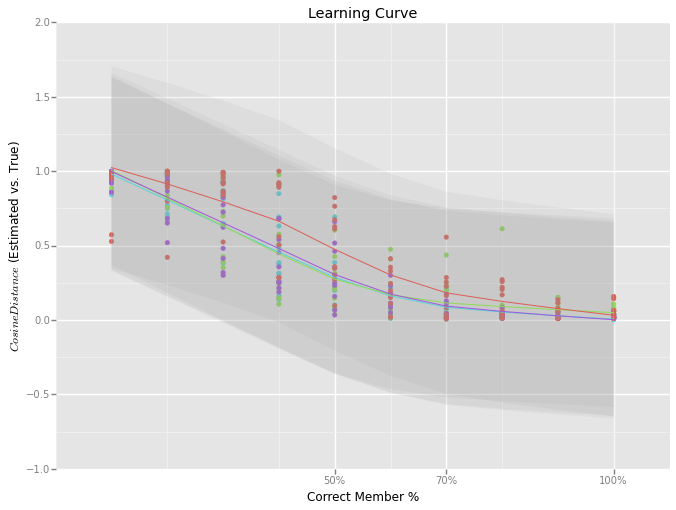

<ggplot: (8782379269437)>

In [246]:
from ggplot import *

#ggplot(aes(x="target_portion", y="mean", group="samp_size"), data=eval_sum) + \
#    geom_line() 
ggplot(aes(x="target_portion", y="theta", group="samp_size", colour="samp_size"), data=eval_df) + \
    geom_point() + \
    stat_smooth(alpha=0.1) + \
    xlab("Correct Member %") + ylab(r"$Cosine Distance$ (Estimated vs. True)") + \
    ggtitle(r"Learning Curve") + \
    xlim(low=0.0, high=1.1) + \
    scale_x_continuous(breaks=[0.5, 0.7, 1], labels=["50%", "70%", "100%"])

## sample hetergenienty 

In [176]:
# examine data sets
# users_df: {"ID", "decision_style"}
# friends_ls: list of tuples

## organize information 
from networkx import Graph

friend_network = Graph()
friend_network.add_edges_from(friends_ls)

#def get_friends_survey(uid, profile_df, graph):
#    uids = graph(friend_network)
user_uids = []
user_styles = []
user_totFriends = []
user_totG0 = []
user_totG1 = []
user_major_friend_groups = []
is_good_samples = []

user_uids = friend_network.nodes()

for uid in user_uids:
    uids = friend_network.neighbors(uid)
    ustyle = users_df.ix[users_df.ID == uid, "decision_style"].values[0]
    styles = [users_df.ix[users_df.ID == i, "decision_style"].values[0] for i in uids]
    tot    = len(styles) 
    num_g0 = sum(np.array(styles) == 0)
    num_g1 = tot - num_g0
    
    mfg = 0 if num_g0 > num_g1 else 1
    is_good = 1 if mfg == ustyle else 0
    
    user_styles.append(ustyle)
    user_totFriends.append(tot)
    user_totG0.append(num_g0)
    user_totG1.append(num_g1)
    user_major_friend_groups.append(mfg)
    is_good_samples.append(is_good)
    
user_friend_profile = pd.DataFrame({"ID": user_uids,
                                    "user_group": user_styles,
                                    "friend_major_group":user_major_friend_groups,
                                    "tot_friends": user_totFriends,
                                    "num_g0": user_totG0,
                                    "num_g1": user_totG1,
                                    "is_good_sample": is_good_samples})

tot_good_samples = sum(user_friend_profile.is_good_sample == 1)
tot_samples = user_friend_profile.shape[0]
good_ptg = 1.0 * tot_good_samples / tot_samples
print "good sample percentage %.2f" % good_ptg

good sample percentage 0.74


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcce9435c10>]], dtype=object)

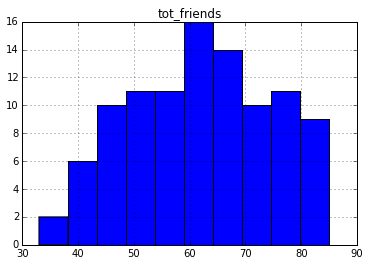

In [178]:
user_friend_profile.hist("tot_friends")

### to improve the data quality, the bad samples need to be reduced
* sim_data_generator: reduce the probability of cross-group friendship.

In [208]:
from networkx import Graph

friend_network = Graph()
friend_network.add_edges_from(friends_ls)

# input variables
weights = true_dist_0
profile_df = profile_df
users_df = users_df      # to profile_df, users_df has "decision_style" column
friends_networkx = friend_network

def get_user_styles(uids, users_df):
    styles = [users_df.ix[users_df.ID == i, "decision_style"].values[0] for i in uids]
    return styles

In [232]:
# parameters
folds = 10
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nsamples = [100, 500, 1000, 1500, 2000]

eval_thresholds = []
eval_nsamples = []
eval_g0_0 = []
eval_g0_1 = []
eval_g0_0_odds = []
eval_g1_0 = []
eval_g1_1 = []
eval_g1_1_odds = []
eval_OR = []

counter = 0
for fold in range(folds):
    for threshold in thresholds:
        for nsamp in nsamples: 
            
            print "%d iteration..." % counter
            counter += 1
            
            g0, g1 = users_filter_by_weights(weights, profile_df, friends_networkx,
                        pval_threshold=threshold,
                        mutate_rate=0.4,
                        min_friend_cnt=10,
                        users_list=None,
                        fit_rayleigh=True,
                        _n=nsamp,
                        is_debug=False)
            
            g0_styles = np.array(get_user_styles(g0, users_df))
            g1_styles = np.array(get_user_styles(g1, users_df))
            
            g0_0 = sum(g0_styles == 0)
            g0_1 = len(g0_styles) - g0_0
            try:
                g0_0_odds = g0_0 * 1.0 / g0_1
            except:
                g0_0_odds = float()
            
            g1_0 = sum(g1_styles == 0) 
            g1_1 = len(g1_styles) - g1_0
            try:
                g1_0_odds = g1_0 * 1.0 / g1_1
            except:
                g1_0_odds = float("inf")
            
            try:
                OR = float(g0_0_odds ) / float(g1_0_odds)
            except:
                OR = float("inf")
            
            eval_thresholds.append(threshold)
            eval_nsamples.append(nsamp)
            eval_g0_0.append(g0_0)
            eval_g0_1.append(g0_1)
            eval_g0_0_odds.append(g0_0_odds)
            eval_g1_0.append(g1_0)
            eval_g1_1.append(g1_1)
            eval_g1_1_odds.append(g1_0_odds)
            eval_OR.append(OR)
            
sens_eval_df = pd.DataFrame({
        "threshold": eval_thresholds,
        "nsample": eval_nsamples,
        "num_s0_in_g0": eval_g0_0, 
        "num_s1_in_g0": eval_g0_1,
        "num_s0_in_g1": eval_g1_0,
        "num_s1_in_g1": eval_g1_1,
        "odds_s0_in_g0": eval_g0_0_odds,
        "odds_s0_in_g1": eval_g1_1_odds,
        "OR": eval_OR
    })

0 iteration...
1 iteration...
2 iteration...
3 iteration...
4 iteration...
5 iteration...
6 iteration...
7 iteration...
8 iteration...
9 iteration...
10 iteration...
11 iteration...
12 iteration...
13 iteration...
14 iteration...
15 iteration...
16 iteration...
17 iteration...
18 iteration...
19 iteration...
20 iteration...
21 iteration...
22 iteration...
23 iteration...
24 iteration...
25 iteration...
26 iteration...
27 iteration...
28 iteration...
29 iteration...
30 iteration...
31 iteration...
32 iteration...
33 iteration...
34 iteration...
35 iteration...
36 iteration...
37 iteration...
38 iteration...
39 iteration...
40 iteration...
41 iteration...
42 iteration...
43 iteration...
44 iteration...
45 iteration...
46 iteration...
47 iteration...
48 iteration...
49 iteration...
50 iteration...
51 iteration...
52 iteration...
53 iteration...
54 iteration...
55 iteration...
56 iteration...
57 iteration...
58 iteration...
59 iteration...
60 iteration...
61 iteration...
62 iteration...
63

ZeroDivisionError: float division by zero

In [248]:
sens_eval_df

,OR,nsample,num_s0_in_g0,num_s0_in_g1,num_s1_in_g0,num_s1_in_g1,odds_s0_in_g0,odds_s0_in_g1,threshold
0,0.791855,100,50,17,26,7,1.923077,2.428571,0.2
1,2.942529,1500,64,3,29,4,2.206897,0.750000,0.2
2,0.367742,100,57,10,31,2,1.838710,5.000000,0.5
3,2.062500,1500,66,1,32,1,2.062500,1.000000,0.5
4,0.451128,100,48,19,28,5,1.714286,3.800000,0.2
5,0.666667,1500,64,3,32,1,2.000000,3.000000,0.2
6,0.458333,100,55,12,30,3,1.833333,4.000000,0.5
7,inf,1500,67,0,32,1,2.093750,0.000000,0.5
